#  Прогнозирование заказов такси

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb


from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit

In [2]:
import warnings
warnings.filterwarnings('ignore')

**Загрузка и информация о данных**

In [3]:
try:
    data = pd.read_csv('taxi.csv')
except:
    print('Ошибка загрузки данных')
    
display(data.head())
data.info()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


**Проверка данных на явные дубликаты и пропуски и монотонность**

In [4]:
print('Количество явных дубликатов:', data.duplicated().sum())
print()
print('Количество пропусков по столбцам', data.isna().sum(), sep='\n')

Количество явных дубликатов: 0

Количество пропусков по столбцам
datetime      0
num_orders    0
dtype: int64


**Смена столбца с индексами на столбец с датами**

In [5]:
# смена типа столбца
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y.%m.%d %H:%M:%S')

# смена столбца с индексами 
data = data.set_index('datetime')

#проверка данных с датой на монотонность
print(data.index.is_monotonic)

True


**Обработка выбросов в столбце "num_orders"**

In [6]:
# создание функции, реализовывающую фильтр Хэмпеля 

def hampel(data, window_size, simg=3):    
    n = len(data)
    new_data = data.copy()
    k = 1.4826
    
    for i in range((window_size),(n - window_size)):
        r_median = np.median(data[(i - window_size):(i + window_size)])  
        r_mad  = np.median(np.abs(data[(i - window_size):(i + window_size)] - r_median))  
        if (np.abs(data[i] - r_median) > simg * r_mad):
            new_data[i] = r_median 
    new_data = new_data.to_frame(name='num_orders')        
    
    return new_data

In [7]:
new_data = hampel(data['num_orders'], 24)

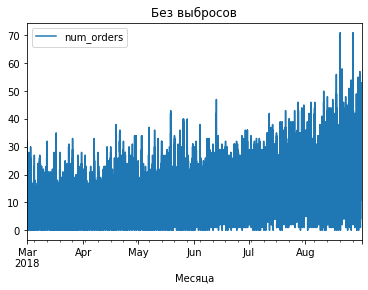

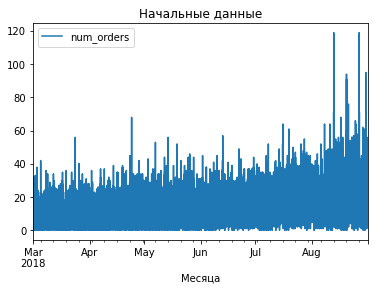

In [8]:
new_data.plot(title='Без выбросов', xlabel='Месяца')
data.plot(title='Начальные данные', xlabel='Месяца')
plt.show()

**Ресемплирование данных**

In [9]:
data = new_data.resample('1H').sum()

**Вывод**

Проведена предобработка данных: данные проверены на явные дубликаты и пропуски, произведена смена столбца с индексами на столбец с датами, произведены выборка и ресемплирование данных.

## Анализ

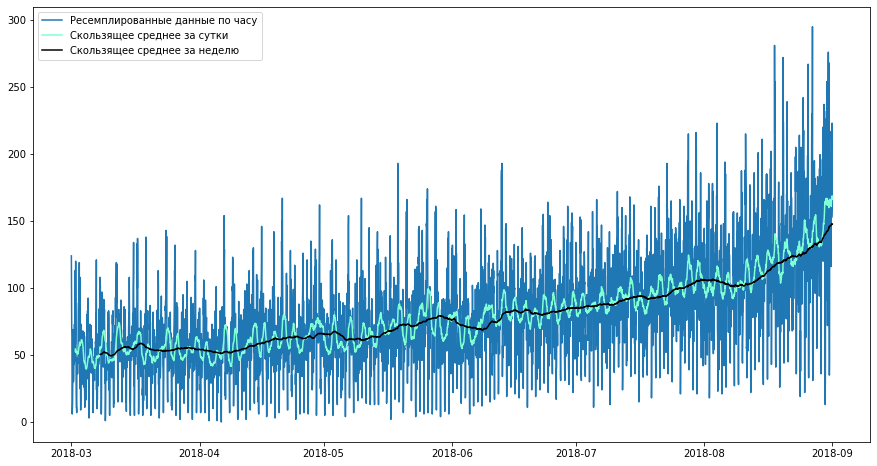

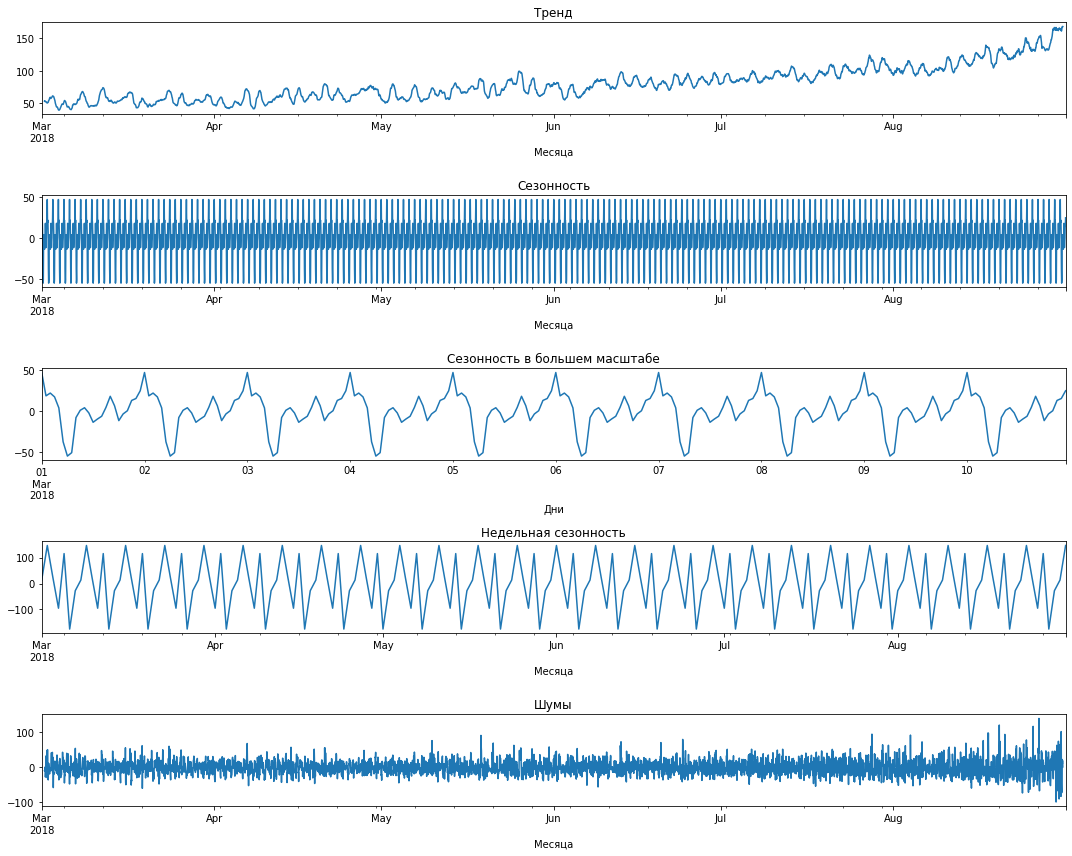

In [10]:
fig, ax = plt.subplots(figsize=(15, 8)) 
 
ax.plot(data, label = 'Ресемплированные данные по часу')
ax.plot(data.rolling(24).mean(), label = 'Скользящее среднее за сутки', color='aquamarine')
ax.plot(data.rolling(168).mean(), label = 'Скользящее среднее за неделю', color='black')
ax.legend(loc='upper left')

plt.show()

decomposed = seasonal_decompose(data['num_orders'])

plt.figure(figsize=(15, 12))


plt.subplot(511)
decomposed.trend.plot(ax=plt.gca(), xlabel='Месяца')
plt.title('Тренд')

plt.subplot(512)
decomposed.seasonal.plot(ax=plt.gca(), xlabel='Месяца') 
plt.title('Сезонность')

plt.subplot(513)
decomposed.seasonal['2018-03-01':'2018-03-10'].plot(ax=plt.gca(), xlabel='Дни') 
plt.title('Сезонность в большем масштабе')

plt.subplot(514)
seasonal_decompose(data.resample('1D').sum()['num_orders']).seasonal.plot(ax=plt.gca(), xlabel='Месяца') 
plt.title('Недельная сезонность')

plt.subplot(515)
decomposed.resid.plot(ax=plt.gca(), xlabel='Месяца')
plt.title('Шумы')
plt.tight_layout()

**Вывод**

1. На графике тренда наблюдается плавное увеличение количества заказов такси с период с начала мая по конец августа. 
2. Наблюдается сезонность для всех исследуемых месяцев (с марта по август), а также недельная сезонность при ресемплировании данных по суткам. 
3. При рассмотрении графика сезонной составляющей при большем масштабе наблюдается спад спроса на такси в ночное время.

## Обучение моделей

**Создание функции для создания признаков**

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()

make_features(data, 24, 24)

**Разделение на обучающую и тестовую выборки**

In [12]:
# разделение на обучающую и тестовую выборки
 
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

# разделение на признаки и целевой признак

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

**Создание функции для вычисления метрики RMSE**

In [13]:
def rmse(t, p):
    return mean_squared_error(t, p) ** 0.5

rmse = make_scorer(rmse, greater_is_better=False)

**МОДЕЛЬ СЛУЧАЙНОГО ЛЕСА**

In [14]:
parameters = {'n_estimators': range(50, 71, 5), 'max_depth': range(1, 10)}
model_rf = RandomForestRegressor(random_state=12345)
tree_grid = GridSearchCV(model_rf, parameters, scoring=rmse, cv=TimeSeriesSplit(), n_jobs=-1, verbose=False)
tree_grid.fit(features_train, target_train)

cv_data = pd.DataFrame(tree_grid.cv_results_)
best_value_rf = -1 * tree_grid.best_score_
best_iter = np.argmax(cv_data['mean_test_score'])
print('Наилучшее значение метрики RMSE: {:.2f} при параметрах {}'.format(
best_value_rf, cv_data['params'][best_iter]))

time_fit_rf = cv_data['mean_fit_time'][best_iter]
time_predict_rf = cv_data['mean_score_time'][best_iter]

print('Время обучения: {:.2f}'.format(time_fit_rf))
print('Время предсказания: {:.2f}'.format(time_predict_rf))

Наилучшее значение метрики RMSE: 22.28 при параметрах {'max_depth': 9, 'n_estimators': 70}
Время обучения: 3.12
Время предсказания: 0.02


**МОДЕЛЬ CatBoost**

In [15]:
parameters = {'iterations': range(100, 120, 5)}
cat_features = ['day', 'dayofweek']
model_cb = CatBoostRegressor() 
cb_grid = GridSearchCV(model_cb, parameters, scoring=rmse, cv=TimeSeriesSplit(), n_jobs=-1, verbose=False)
cb_grid.fit(features_train, target_train, cat_features=cat_features, verbose=False)

cv_data = pd.DataFrame(cb_grid.cv_results_)
best_value_cb = -1 * cb_grid.best_score_
best_iter = np.argmax(cv_data['mean_test_score'])
print('Наилучшее значение метрики RMSE: {:.2f} при параметрах {}'.format(
best_value_cb, cv_data['params'][best_iter]))

time_fit_cb = cv_data['mean_fit_time'][best_iter]
time_predict_cb = cv_data['mean_score_time'][best_iter]

print('Время обучения: {:.2f}'.format(time_fit_cb))
print('Время предсказания: {:.2f}'.format(time_predict_cb))

Наилучшее значение метрики RMSE: 21.73 при параметрах {'iterations': 110}
Время обучения: 4.57
Время предсказания: 0.00


**МОДЕЛЬ LightBGM**

In [16]:
parameters = {'n_estimators': range(150, 201, 5), 'max_depth': range(1, 10)}
model_l= lgb.LGBMRegressor()
l_grid = GridSearchCV(model_l, parameters, scoring=rmse, cv=TimeSeriesSplit(), n_jobs=-1, verbose=10)
l_grid.fit(features_train, target_train)

cv_data = pd.DataFrame(l_grid.cv_results_)
best_value_l = -1 * l_grid.best_score_
best_iter = np.argmax(cv_data['mean_test_score'])
print('Наилучшее значение метрики RMSE: {:.2f} при параметрах {}'.format(
best_value_l, cv_data['params'][best_iter]))

time_fit_l = cv_data['mean_fit_time'][best_iter]
time_predict_l = cv_data['mean_score_time'][best_iter]

print('Время обучения: {:.2f}'.format(time_fit_l))
print('Время предсказания: {:.2f}'.format(time_predict_l))

Fitting 5 folds for each of 99 candidates, totalling 495 fits
Наилучшее значение метрики RMSE: 21.72 при параметрах {'max_depth': 3, 'n_estimators': 170}
Время обучения: 0.18
Время предсказания: 0.01


**АНАЛИЗ МОДЕЛЕЙ**

In [17]:
table = pd.DataFrame({'Случайный лес': [best_value_rf, time_fit_rf, time_predict_rf], 
                     'CatBoost': [best_value_cb, time_fit_cb, time_predict_cb], 
                     'LightGBM': [best_value_l, time_fit_l, time_predict_l]}, 
                    index=['RMSE на обучающей выборке', 'Время обучения, с', 'Время предсказания, с'])

print('Сводная таблица значений RMSE и времён обучения и предсказания моделей')
table.style.format({'Случайный лес': '{:.2f}', 'CatBoost': '{:.2f}', 'LightGBM': '{:.2f}'})

Сводная таблица значений RMSE и времён обучения и предсказания моделей


,Случайный лес,CatBoost,LightGBM
RMSE на обучающей выборке,22.28,21.73,21.72
"Время обучения, с",3.12,4.57,0.18
"Время предсказания, с",0.02,0.00,0.01


**Вывод**

Учитывая совокупность значений метрики RMSE и времён обучения и предсказания, наилучшей моделью является модель LightGBM.

## Тестирование

In [18]:
# обучение наилучшей модели

model_l= lgb.LGBMRegressor(max_depth=3, n_estimators=170)
model_l.fit(features_train, target_train)

print('Значение метрики RMSE на тестовой выборке {:.2f}'.\
      format(mean_squared_error(model_l.predict(features_test), target_test) ** 0.5))

Значение метрики RMSE на тестовой выборке 36.17


## Вывод

Наиболее эффективной моделью является модель LightGBM: значение метрики RMSE составило 21.72, время обучения и предсказания 0.18 и 0.01 секунды соответственно. 

Значение метрики RMSE на тестовой выборке при использовании модели LightGBM равно 36.17 при параметрах модели max_depth=3 и n_estimators=170.